**GOAL of the MVP:(DOCTOR-ASSISTANT)**


SAMPLE USE-CASE:
*   The conversations between eve and patients can be incorporated into a RAG-model.
*   Legally permitted Health care provider can extract insights about patients from the conversations at-ease in a time-efficient way with simple Natural language query.
*   For ex: The health care provider can query to find out how the patient feels about a particular type of treatment or medication...etc







**ARCHITECTURE FLOW**

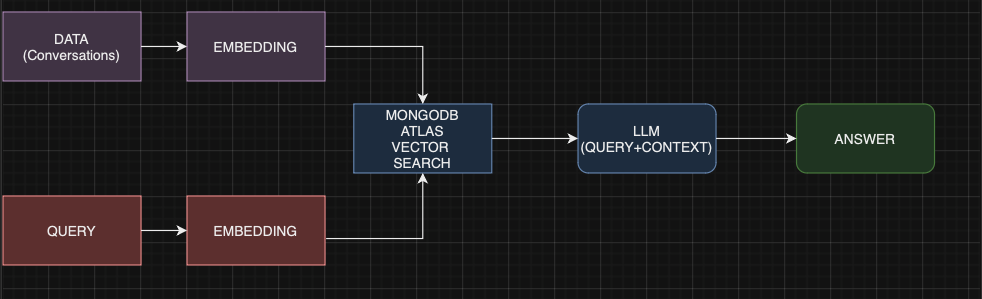



**EMBEDDING MODEL USED:"BAAI/bge-large-en-v1.5"**

This embedding model can understand chinese and will be useful if the MedDialog dataset is to be used: https://paperswithcode.com/dataset/meddialog#:~:text=Medical%20Dialogue%20Datasets-,The%20MedDialog%20dataset%20(Chinese)%20contains%20conversations%20(in%20Chinese),more%20dialogues%20will%20be%20added.






**LLM USED: Mistral-7B-Instruct-v0.2**

The Mistral-7B-Instruct-v0.2 Large Language Model (LLM) is an improved instruct fine-tuned version of Mistral-7B-Instruct-v0.1.

In [ ]:
#dependencies
!pip install llama-index-embeddings-huggingface
!pip install llama-index-llms-llama-cpp
!pip install llama-cpp-python
!pip install llama-index-embeddings-langchain
!pip3 install huggingface-hub
!pip install langchain
!pip install transformers --upgrade

In [ ]:
## Check if GPU is enabled
import os
import torch

## To disable GPU and experiment, uncomment the following line
## Normally, you would want to use GPU, if one is available.
# os.environ["CUDA_VISIBLE_DEVICES"]=""

print ("using CUDA/GPU: ", torch.cuda.is_available())

for i in range(torch.cuda.device_count()):
   print("device ", i , torch.cuda.get_device_properties(i).name)

using CUDA/GPU:  True
device  0 Tesla T4


In [ ]:
# We will keep all global variables in an object to not pollute the global namespace.
class MyConfig(object):
    pass

MY_CONFIG = MyConfig()

## Atlas settings
MY_CONFIG.DB_NAME = 'conversations'
MY_CONFIG.COLLECTION_NAME = 'convo'
MY_CONFIG.EMBEDDING_ATTRIBUTE = 'embedding_local'
MY_CONFIG.INDEX_NAME = 'convo_index'

## Embedding settings
## Option 1 : small model - about 133 MB size
## Option 2 : large model - about 1.34 GB
## See Step-12 for more details

#MY_CONFIG.EMBEDDING_MODEL = "BAAI/bge-small-en-v1.5"

In [ ]:
# are we running in Colab?
import os

if os.getenv("COLAB_RELEASE_TAG"):
    print("Running in Colab")
    MY_CONFIG.RUNNING_IN_COLAB = True
else:
    print("NOT running in Colab")
    MY_CONFIG.RUNNING_IN_COLAB = False

Running in Colab


In [ ]:
if MY_CONFIG.RUNNING_IN_COLAB:
    !pip install \
                openai \
                pymongo==4.6.2 \
                llama-index \
                llama-index-embeddings-huggingface \
                llama-index-embeddings-openai \
                llama-index-vector-stores-mongodb \
                transformers==4.38.2 \
                sentence_transformers==2.5.1 \
                torch==2.2.1

In [ ]:
## Setup logging.  To see more loging set the level to DEBUG

import sys
import logging

# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, level=logging.WARN)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [ ]:
## Load settings based on where we are running
##  - if runninning on google Colab, load from secrets
##  - if running locally use dotenv

if MY_CONFIG.RUNNING_IN_COLAB:
    from google.colab import userdata
    MY_CONFIG.ATLAS_URI = userdata.get('ATLAS_URI')
    # MY_CONFIG.OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
else:
    import os, sys
    from dotenv import find_dotenv, dotenv_values

    this_dir = os.path.abspath('')
    parent_dir = os.path.dirname(this_dir)
    sys.path.append (os.path.abspath (parent_dir))

    config = dotenv_values(find_dotenv())
    # debug
    # print (config)
    MY_CONFIG.ATLAS_URI = config.get('ATLAS_URI')
## --- end load config

## If you just want to quickly set the config manually, you can do so here.
# MY_CONFIG.ATLAS_URI = ''

if  MY_CONFIG.ATLAS_URI:
    print ("✅ config ATLAS_URI found")
else:
    raise Exception ("'❌ ATLAS_URI' is not set.  Please set it above to continue...")

✅ config ATLAS_URI found


In [ ]:
import os

# ------- begin -------
def download_data_file (remote_file, local_file):
     if  os.path.exists (local_file):
         print (f"✅ Local data files exists : {local_file}")
     else:
        !wget -O {local_file}  {remote_file}
        print (f"✅ Downloaded data file : {local_file}")
#-------- end -------

# figure out data dir
if MY_CONFIG.RUNNING_IN_COLAB:
    MY_CONFIG.DATA_DIR = "data/conversations"
else:
    MY_CONFIG.DATA_DIR = "../data/conversations"


In [ ]:
import pymongo

mongodb_client = pymongo.MongoClient(MY_CONFIG.ATLAS_URI)
print ('✅ Connected to Atlas instance!')

✅ Connected to Atlas instance!


In [ ]:
## if a clean start is required, you can use the following code to clear out old data

database = mongodb_client[MY_CONFIG.DB_NAME]
collection = database [MY_CONFIG.COLLECTION_NAME]

doc_count = collection.count_documents (filter = {})
print (f"Document count in collection '{MY_CONFIG.DB_NAME}.{MY_CONFIG.COLLECTION_NAME}' before delete : {doc_count:,}")

result = collection.delete_many(filter= {})
print (f"Deleted docs : {result.deleted_count}")

Document count in collection 'conversations.convo' before delete : 9
Deleted docs : 9


In [ ]:
!pip install -U langchain-nomic

In [ ]:
from langchain_nomic.embeddings import NomicEmbeddings

embeddings = NomicEmbeddings(model="nomic-embed-text-v1.5", dimensionality=768)

In [ ]:
"""
from langchain.embeddings import HuggingFaceBgeEmbeddings
model_name = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
model = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)
"""

'\nfrom langchain.embeddings import HuggingFaceBgeEmbeddings\nmodel_name = "BAAI/bge-large-en-v1.5"\nmodel_kwargs = {\'device\': \'cuda\'}\nencode_kwargs = {\'normalize_embeddings\': True} # set True to compute cosine similarity\nmodel = HuggingFaceBgeEmbeddings(\n    model_name=model_name,\n    model_kwargs=model_kwargs,\n    encode_kwargs=encode_kwargs,\n)\n'

In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

Settings.embed_model = embeddings

In [ ]:
from llama_index.vector_stores.mongodb import MongoDBAtlasVectorSearch
from llama_index.core import StorageContext


vector_store = MongoDBAtlasVectorSearch(mongodb_client = mongodb_client,
                                        db_name = MY_CONFIG.DB_NAME,
                                        collection_name = MY_CONFIG.COLLECTION_NAME,
                                        index_name  = MY_CONFIG.INDEX_NAME,
                                        embedding_key = MY_CONFIG.EMBEDDING_ATTRIBUTE,
                                        ## the following columns are set to default values
                                       # text_key = 'text', metadata_= 'metadata',
                                 )
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [ ]:
%%time

from llama_index.core import SimpleDirectoryReader
docs = SimpleDirectoryReader(
        input_dir=MY_CONFIG.DATA_DIR
).load_data()

print (f"Loaded {len(docs)} chunks from '{MY_CONFIG.DATA_DIR}'")

Loaded 8 chunks from 'data/conversations'
CPU times: user 556 ms, sys: 16 ms, total: 572 ms
Wall time: 647 ms


In [ ]:
%%time

from llama_index.core import VectorStoreIndex

index = VectorStoreIndex.from_documents(
    docs, storage_context=storage_context
)


CPU times: user 768 ms, sys: 13.8 ms, total: 782 ms
Wall time: 885 ms


In [ ]:
!huggingface-cli download TheBloke/Mistral-7B-Instruct-v0.2-GGUF mistral-7b-instruct-v0.2.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf to /root/.cache/huggingface/hub/tmprhzuqnvv
mistral-7b-instruct-v0.2.Q4_K_M.gguf: 100% 4.37G/4.37G [00:51<00:00, 84.6MB/s]
./mistral-7b-instruct-v0.2.Q4_K_M.gguf


In [ ]:
model_file_path = '/content/mistral-7b-instruct-v0.2.Q4_K_M.gguf'

In [ ]:
from llama_index.llms.llama_cpp import LlamaCPP
from llama_index.llms.llama_cpp.llama_utils import (
    messages_to_prompt,
    completion_to_prompt,
)

llm = LlamaCPP(
    # You can pass in the URL to a GGML model to download it automatically
    # model_url=model_url,
    # optionally, you can set the path to a pre-downloaded model instead of model_url
    model_path=model_file_path,
    temperature=0.1,
    max_new_tokens=256,
    # llama2 has a context window of 4096 tokens, but we set it lower to allow for some wiggle room
    context_window=3900,
    # kwargs to pass to __call__()
    generate_kwargs={},
    # kwargs to pass to __init__()
    # set to at least 1 to use GPU,  0 for no GPU, -1 to offload every thing to GPU
    # change this value from 1, 10, 20, 30, 40
    # for Nvidia GEForce 2070 with 8 GB RAM 40 works well
    model_kwargs={"n_gpu_layers": -1},
    # transform inputs into Llama2 format
    messages_to_prompt=messages_to_prompt,
    completion_to_prompt=completion_to_prompt,
    verbose=True,
)
Settings.llm = llm

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /content/mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:         

In [ ]:
from transformers import AutoTokenizer
from llama_index.core import Settings

tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2"
)

Settings.tokenzier = tokenizer

In [ ]:
%%time

from IPython.display import Markdown
from pprint import pprint

query = "Take the ending of the Pokemon story, extend the story as what would happen next and write dialogues"
response = index.as_query_engine().query(query)
print (response)
print()
pprint(response, indent=4)

Llama.generate: prefix-match hit

llama_print_timings:        load time =  229026.33 ms
llama_print_timings:      sample time =     157.03 ms /   256 runs   (    0.61 ms per token,  1630.26 tokens per second)
llama_print_timings: prompt eval time =  182294.94 ms /   401 tokens (  454.60 ms per token,     2.20 tokens per second)
llama_print_timings:        eval time =  174162.31 ms /   255 runs   (  682.99 ms per token,     1.46 tokens per second)
llama_print_timings:       total time =  357588.33 ms /   656 tokens


 Ash and Gary, both determined and focused, prepared their best Pokemon for the upcoming one-on-one battle. The tension in the air was palpable as they called out their respective champions.

Ash sent out his Charizard, its fiery eyes gleaming with determination. Gary countered with his Blastoise, its massive shell reflecting the light of the setting sun. The crowd held their breath as the two Pokemon faced off against each other.

"Charizard, use Flamethrower!" Ash commanded. Charizard opened its mouth and unleashed a stream of flames towards Blastoise.

Blastoise retaliated with "Hydro Pump," sending a powerful jet of water straight at Charizard. The two elemental attacks collided in mid-air, creating a spectacular display of fire and water.

The crowd watched in awe as the two Pokemon continued to exchange moves, neither gaining the upper hand. Tracey, Misty, and Brock could only watch in silence, their earlier bickering forgotten in the intensity of the battle.

Suddenly, Charizard

In [ ]:
story = response.response
scenes = story.splitlines()
scenes = [scene for scene in scenes if scene.strip()]
theme_query = "Generate an Pokemon style anime comic strip image of:"
scenes_themed = [f"{theme_query} {scene}" for scene in scenes]

In [ ]:
import requests

API_URL = "https://api-inference.huggingface.co/models/stabilityai/stable-diffusion-xl-base-1.0"
headers = {"Authorization": f"HF_TOKEN"}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.content
image_bytes = query({
	"inputs": response.response,
})

In [ ]:
# Create a list to store generated images
images = []

# Loop over each scene, generate image, and append to 'images' list
for scene in scenes_themed:
    image_bytes = query({"inputs": scene})
    image = Image.open(io.BytesIO(image_bytes))
    images.append(image)

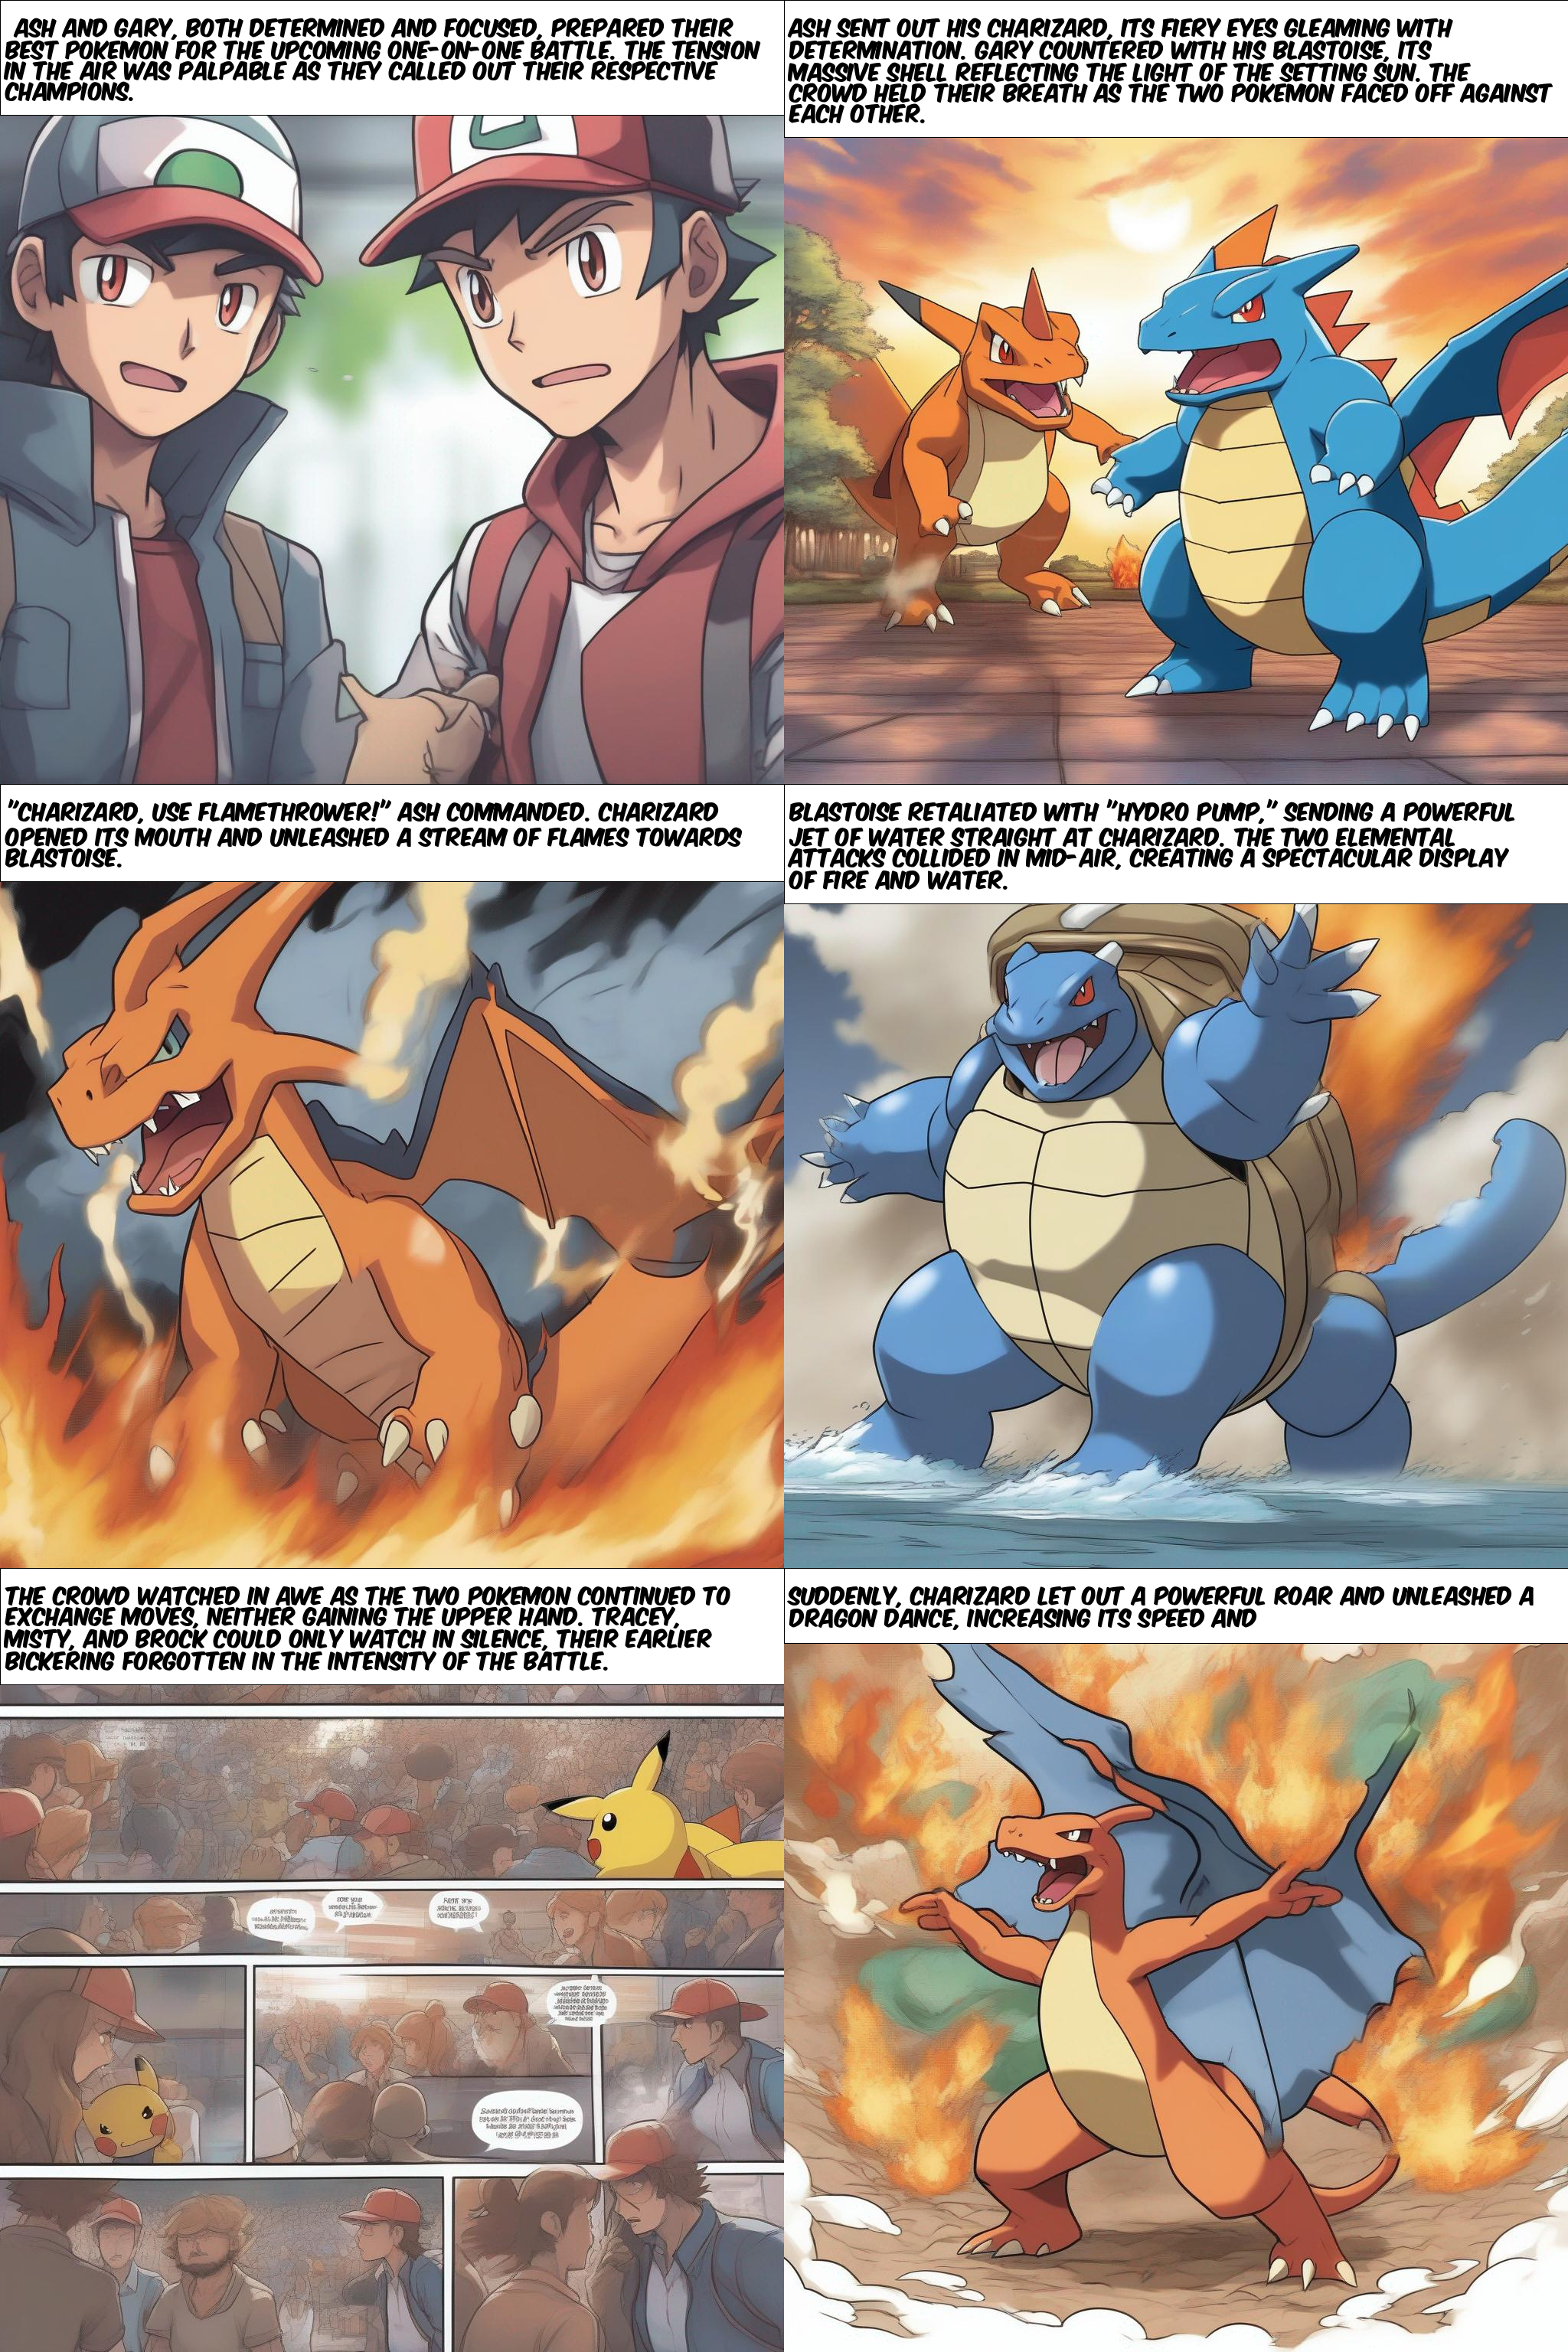

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import textwrap

# Function to wrap text into lines of specified width
def wrap_text(text, width=60):
    return textwrap.fill(text, width=width)

# Calculate dimensions for the new image
num_images = len(images)
num_rows = (num_images + 1) // 2  # Round up to the nearest integer
image_width = max(image.width for image in images)
image_height = max(image.height for image in images)
new_width = image_width * 2
new_height = image_height * num_rows

# Create a new image with white background
new_image = Image.new('RGB', (new_width, new_height), color='white')

# Paste images into new image and overlay with text
draw = ImageDraw.Draw(new_image)
font_size = 27  # Increase font size here
# Load a font
font_path = "KOMIKAX_.ttf"  # Replace with the path to your font file
font = ImageFont.truetype(font_path, font_size)

x_offset = 0
y_offset = 0
for i, (image, scene) in enumerate(zip(images, scenes)):
    # Paste image
    new_image.paste(image, (x_offset, y_offset))

    # Wrap the scene text
    wrapped_text = wrap_text(scene)
    wrapped_text_lines = wrapped_text.split('\n')  # Split wrapped text into lines

    # Calculate text height for wrapped text
    text_height = sum(draw.textbbox((0, 0), line, font=font)[3] - draw.textbbox((0, 0), line, font=font)[1] for line in wrapped_text_lines)

    # Draw white textbox with black border
    text_bbox = (x_offset , y_offset , x_offset + image_width , y_offset+40 + text_height)  # Adjust the height based on text height
    draw.rectangle(text_bbox, fill='white', outline='black')

    # Draw wrapped text line by line
    y = y_offset + 10  # Starting y-coordinate for drawing text
    for line in wrapped_text_lines:
        line_bbox = draw.textbbox((x_offset + 10, y), line, font=font)
        draw.text((line_bbox[0], y), line, fill='black', font=font)  # Adjust text position
        y += line_bbox[3] - line_bbox[1]  # Increment y-coordinate for next line

    # Update x_offset and y_offset
    x_offset += image_width
    if i % 2 == 1:
        x_offset = 0
        y_offset += image_height

# Display the concatenated image with text overlay
new_image


In [ ]:
new_image.save("output_image.png")